<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [140]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [141]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

mu_data.info()
mu_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


<Axes: xlabel='Date'>

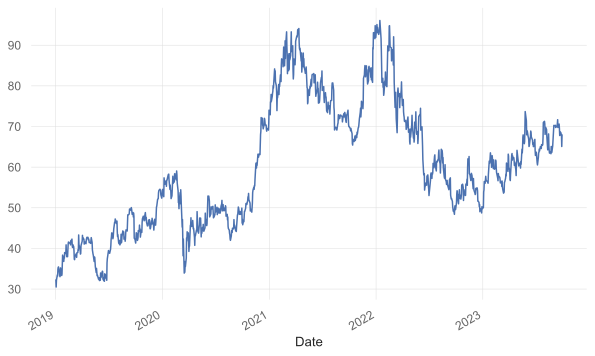

In [142]:
# Daily close price data for MU
mu_data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [143]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = mu_data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.058255


## 3. Define statistical trading strategy (at least one, maximum 2)

In [144]:
# Exponential moving average (EMA) strategy
def ema_strategy(data):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 20-day moving average is above the 100-day moving average, sell otherwise
    signals = pd.DataFrame(data)

    # EMA for 10 and 50-day windows
    signals['ema_short'] = signals['Close'].ewm(span = 20, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = 100, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, -1)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

C:\Users\Admin\AppData\Local\Temp\ipykernel_16896\800439249.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')


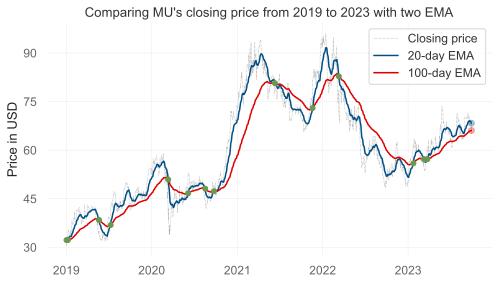

In [145]:
# Initiate strategy
ema = ema_strategy(mu_data)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema.index[-1], ema['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema.index[-1], ema['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema['crossover']).flatten()
ax.plot(ema['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()


<Axes: title={'center': 'Strategy Positioning'}, xlabel='Date'>

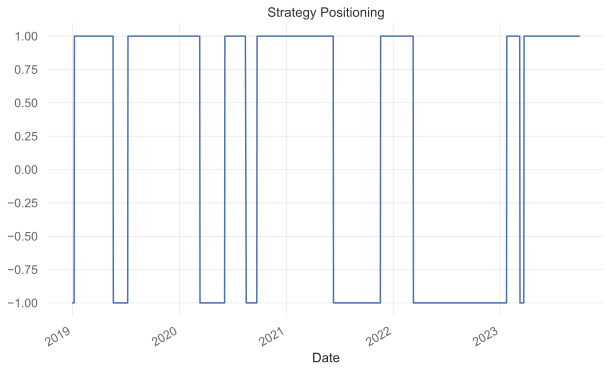

In [146]:
# Plot our strategy's positions
ema['bullish'].plot(ylim=[-1.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

returns     187.767510
strategy   -128.189839
dtype: float64

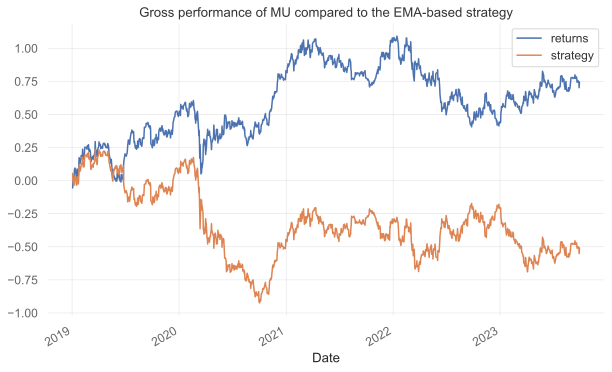

In [147]:
# Plot our strategy's returns compared to MU's stock performance
ema[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema[['returns', 'strategy']].sum() * 252

## 4. Evaluate the efficacy of the trading strategy

In [148]:
qs.reports.metrics(ema['strategy'])

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -63.89%
CAGR﹪              -13.79%

Sharpe              -0.23
Prob. Sharpe Ratio  30.72%
Sortino             -0.32
Sortino/√2          -0.23
Omega               0.96

Max Drawdown        -74.94%
Longest DD Days     1653

Gain/Pain Ratio     -0.04
Gain/Pain (1M)      -0.17

Payoff Ratio        0.97
Profit Factor       0.96
Common Sense Ratio  0.94
CPC Index           0.46
Tail Ratio          0.98
Outlier Win Ratio   3.15
Outlier Loss Ratio  3.62

MTD                 -3.04%
3M                  0.22%
6M                  11.14%
YTD                 -30.39%
1Y                  -30.98%
3Y (ann.)           2.12%
5Y (ann.)           -13.79%
10Y (ann.)          -13.79%
All-time (ann.)     -13.79%

Avg. Drawdown       -15.68%
Avg. Drawdown Days  245
Recovery Factor     0.68
Ulcer Index         0.56
Sereni

## 4. Use at least one reinforcement learning algorithm for trading the assets (Q-learning, deep Q-learning)

In [157]:
# create environment with specific parameters
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 

env = gym.make('stocks-v0',
    df = mu_data,
    window_size=5,
    # frame_bound=(50, 100),
)

In [150]:
# print information
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (5, 2)
> df.shape: (1195, 7)
> prices.shape: (1170,)
> signal_features.shape: (1170, 2)
> max_possible_profit: 312545.2166896185


info: {'total_reward': -449162.6739501953, 'total_profit': 0.5384810232478897, 'position': <Positions.Long: 1>}


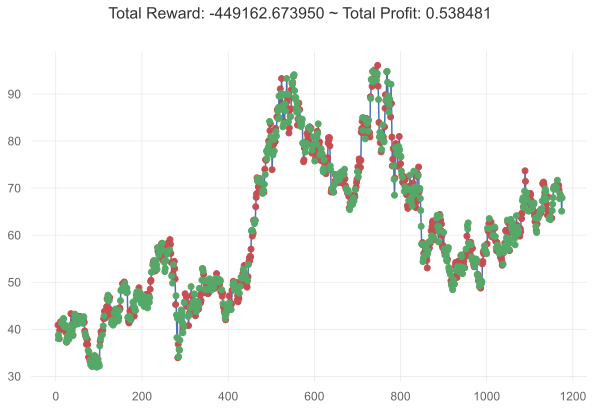

In [156]:
observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

## 5. Compare Statistical method to RL strategy

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-04   2019-01-04
End Period                 2023-08-16   2023-08-16
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       25.0%

Cumulative Return          -67.53%      -95.66%
CAGR﹪                     -15.48%      -37.45%

Sharpe                     -0.29        -1.88
Prob. Sharpe Ratio         26.78%       0.01%
Smart Sharpe               -0.28        -1.86
Sortino                    -0.4         -2.4
Smart Sortino              -0.39        -2.36
Sortino/√2                 -0.28        -1.7
Smart Sortino/√2           -0.28        -1.67
Omega                      0.51         0.51

Max Drawdown               -74.94%      -95.62%
Longest DD Days            1609         1676
Volatility (ann.)          46.67%       33.16%
R^2                        0.0          0.0
Information Ratio          -0.06        -0.06
Calmar        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-01-14,2023-08-10,2023-08-16,1676,-95.618834,-95.532886


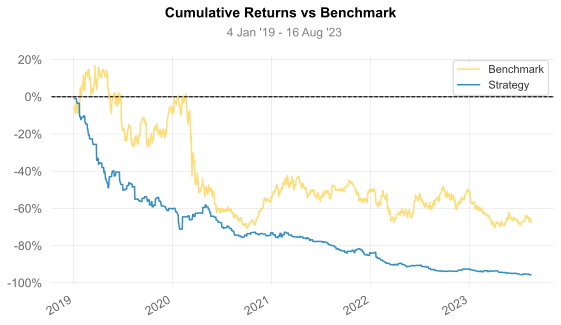

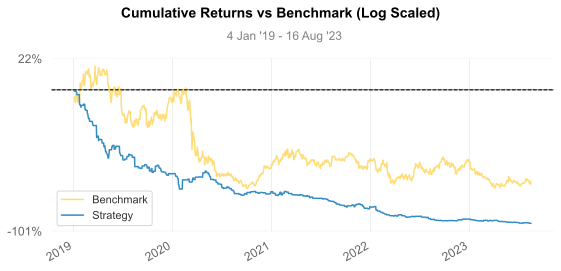

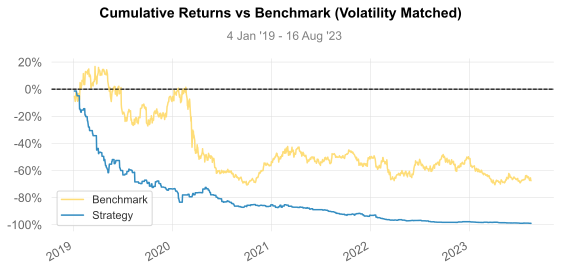

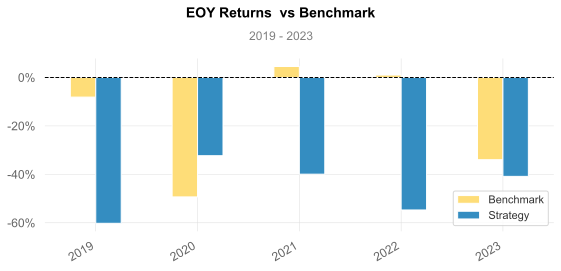

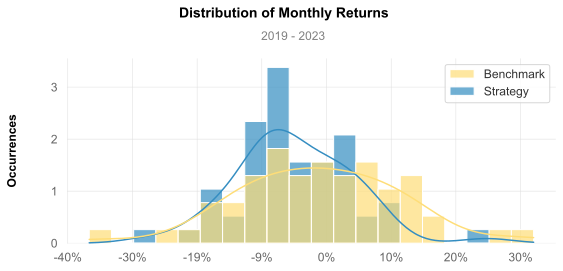

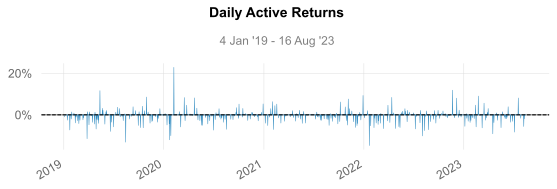

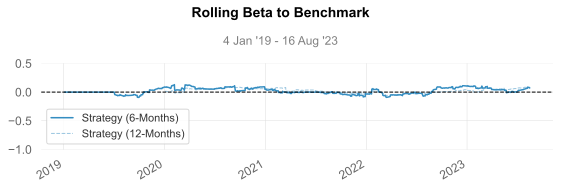

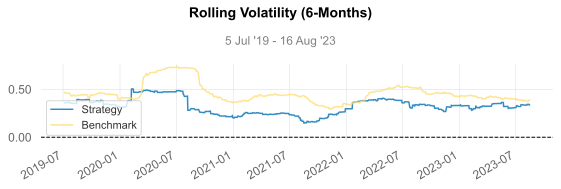

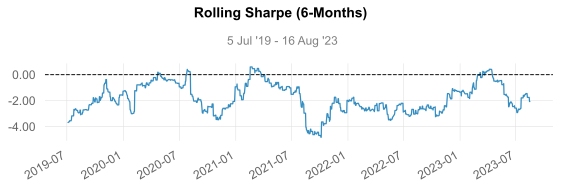

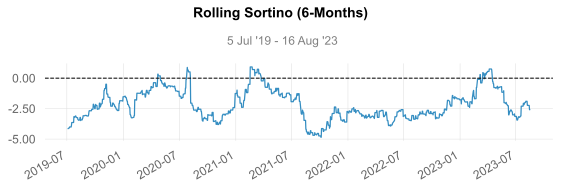

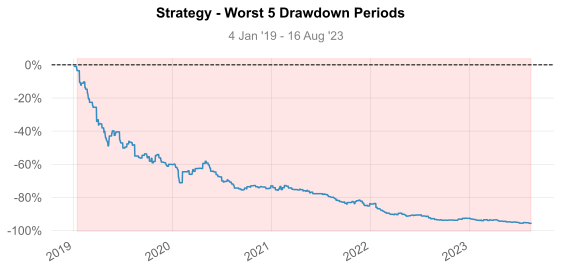

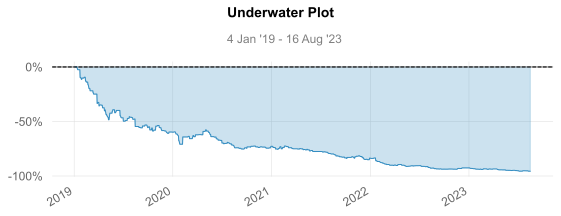

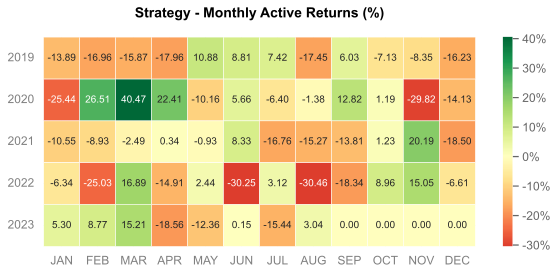

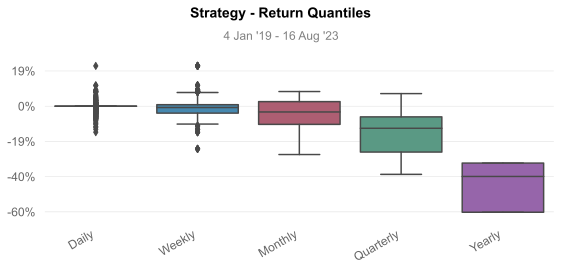

In [154]:
# Comparison metrics and plots between EMA and RL strategies
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1164])
rl_returns = net_worth.pct_change().iloc[1:]

ema_series = pd.Series(ema['strategy'], index=mu_data.index[0:1164])

rl_returns = rl_returns.tz_localize(None)
ema_returns = ema_series.tz_localize(None)

qs.reports.full(rl_returns, ema_returns)

## 7. Fine-tune your algorithms

In [ ]:
'''Insert code here'''

## 8. Compare and interpret the results

In [ ]:
'''Insert code here'''